# 02 - Format Benchmark: CSV vs. Parquet vs. Delta Lake

**Objective:** Compare I/O performance and storage efficiency across different file formats.

This notebook measures:
1. **Read Performance**: Time to load data from each format
2. **Storage Efficiency**: Disk space used by each format
3. **Query Performance**: Aggregation speed (columnar vs. row-oriented)
4. **Filter Pushdown**: Predicate pushdown effectiveness

---

## Setup and Imports

In [1]:
# Add src directory to path
import sys
from pathlib import Path

notebook_dir = Path.cwd()
project_root = notebook_dir.parent
src_dir = project_root / "src"
sys.path.insert(0, str(src_dir))

print(f"Project root: {project_root}")
print(f"Src directory: {src_dir}")

Project root: C:\Users\samvo\source\repos\Spark-Performance-Benchmark
Src directory: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\src


In [2]:
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import project modules
from config import (
    get_data_path,
    SPARK_APP_NAME,
    PLOTS_DIR,
    configure_hadoop_home
)

# 1. HADOOP_HOME setzen
configure_hadoop_home()

# 2. WICHTIG: bin-Ordner explizit zum System-PATH hinzufügen
# Damit findet die JVM die hadoop.dll garantiert
if os.environ.get('HADOOP_HOME'):
    bin_path = os.path.join(os.environ['HADOOP_HOME'], 'bin')
    if bin_path not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + bin_path
        print(f"✓ Added to PATH: {bin_path}")

from benchmark_utils import BenchmarkTimer, get_directory_size_mb, print_benchmark_summary

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful & Hadoop configured")


✓ All directories verified/created successfully
✓ HADOOP_HOME already set: C:\hadoop
✓ Added to PATH: C:\hadoop\bin
✓ All imports successful & Hadoop configured


## Initialize Spark Session

In [3]:
# Create Spark session with Delta Lake support
spark = (
    SparkSession.builder
    .appName(f"{SPARK_APP_NAME} - Format Benchmark")
    .master("local[*]")
    # WICHTIG: Diese Zeile hat gefehlt! Sie lädt den Delta-Code herunter:
    .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.0.0") 
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.warehouse.dir", "file:///C:/temp") # Hilft oft bei Windows Permissions
    .getOrCreate()
)

print(f"✓ Spark {spark.version} session initialized")
print(f"✓ App Name: {spark.sparkContext.appName}")

✓ Spark 3.5.0 session initialized
✓ App Name: SparkPerformanceBenchmark - Format Benchmark


## Storage Size Comparison

First, let's compare the disk space used by each format.

In [4]:
# Calculate storage sizes for all formats
storage_data = []

for table_name in ["fact_transactions", "dim_accounts"]:
    for fmt in ['csv', 'parquet', 'delta']:
        path = get_data_path(fmt, table_name)
        if path.exists():
            size_mb = get_directory_size_mb(path)
            storage_data.append({
                'Table': table_name,
                'Format': fmt.upper(),
                'Size_MB': size_mb
            })

# Create DataFrame
storage_df = pd.DataFrame(storage_data)

# Display results
print("="*60)
print("STORAGE SIZE COMPARISON")
print("="*60)
print(storage_df.to_string(index=False))
print("="*60)

STORAGE SIZE COMPARISON
            Table  Format    Size_MB
fact_transactions     CSV 552.894993
fact_transactions PARQUET 290.375078
fact_transactions   DELTA 862.776222
     dim_accounts     CSV 337.201606
     dim_accounts PARQUET 112.840783
     dim_accounts   DELTA 225.712968


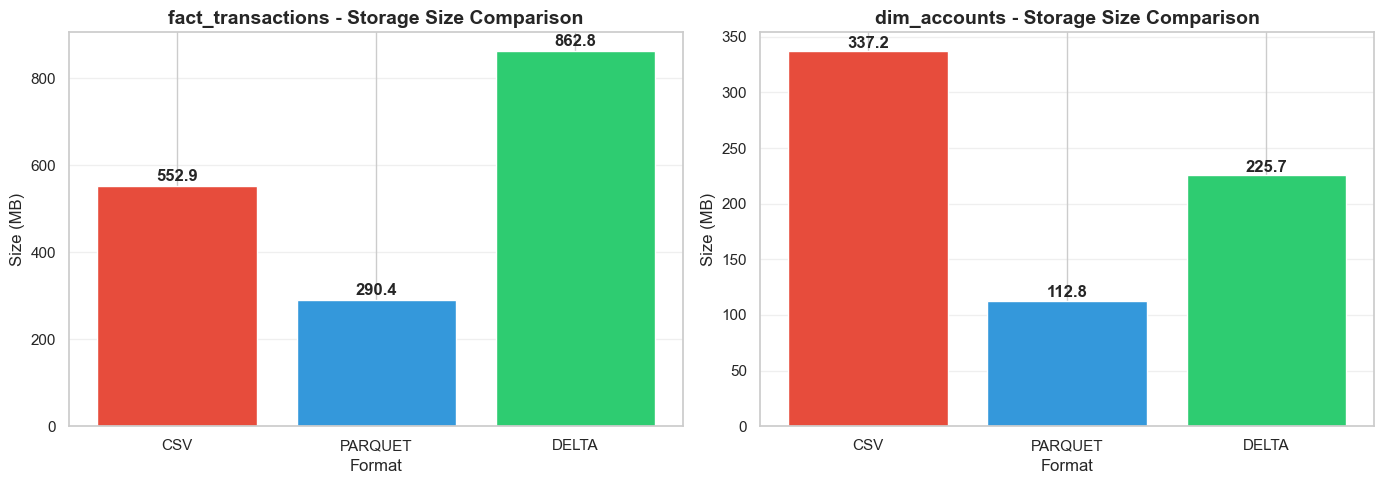

✓ Plot saved to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\plots\storage_comparison.png


In [5]:
# Visualize storage comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for fact_transactions
sales_data = storage_df[storage_df['Table'] == "fact_transactions"]
axes[0].bar(sales_data['Format'], sales_data['Size_MB'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[0].set_title('fact_transactions - Storage Size Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Size (MB)', fontsize=12)
axes[0].set_xlabel('Format', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(sales_data['Size_MB']):
    axes[0].text(i, v + 5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot for dim_accounts
customer_data = storage_df[storage_df['Table'] == "dim_accounts"]
axes[1].bar(customer_data['Format'], customer_data['Size_MB'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[1].set_title('dim_accounts - Storage Size Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Size (MB)', fontsize=12)
axes[1].set_xlabel('Format', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(customer_data['Size_MB']):
    axes[1].text(i, v + 0.2, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'storage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {PLOTS_DIR / 'storage_comparison.png'}")

## Benchmark 1: Full Scan Read Performance

Measure how long it takes to read and count all records from each format.

In [6]:
# Test CSV read performance
with BenchmarkTimer(
    "Read CSV - fact_transactions (Full Scan)",
    description="Load and count all records from CSV",
    spark=spark,
    clear_cache=True
) as timer:
    csv_df = spark.read.option("header", "true").option("inferSchema", "true").csv(
        str(get_data_path("csv", "fact_transactions"))
    )
    count = csv_df.count()
    print(f"Records: {count:,}")

✓ Cache cleared for: Read CSV - fact_transactions (Full Scan)

Starting benchmark: Read CSV - fact_transactions (Full Scan)
Description: Load and count all records from CSV
Records: 6,362,620

✓ Completed: Read CSV - fact_transactions (Full Scan)
Duration: 33.368 seconds (0.56 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [7]:
# Test Parquet read performance
with BenchmarkTimer(
    "Read Parquet - fact_transactions (Full Scan)",
    description="Load and count all records from Parquet",
    spark=spark,
    clear_cache=True
) as timer:
    parquet_df = spark.read.parquet(str(get_data_path("parquet", "fact_transactions")))
    count = parquet_df.count()
    print(f"Records: {count:,}")

✓ Cache cleared for: Read Parquet - fact_transactions (Full Scan)

Starting benchmark: Read Parquet - fact_transactions (Full Scan)
Description: Load and count all records from Parquet
Records: 6,362,620

✓ Completed: Read Parquet - fact_transactions (Full Scan)
Duration: 4.348 seconds (0.07 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [8]:
# Test Delta read performance
with BenchmarkTimer(
    "Read Delta - fact_transactions (Full Scan)",
    description="Load and count all records from Delta",
    spark=spark,
    clear_cache=True
) as timer:
    delta_df = spark.read.format("delta").load(str(get_data_path("delta", "fact_transactions")))
    count = delta_df.count()
    print(f"Records: {count:,}")

✓ Cache cleared for: Read Delta - fact_transactions (Full Scan)

Starting benchmark: Read Delta - fact_transactions (Full Scan)
Description: Load and count all records from Delta
Records: 6,362,620

✓ Completed: Read Delta - fact_transactions (Full Scan)
Duration: 33.288 seconds (0.55 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


## Benchmark 2: Columnar Aggregation Performance

Test aggregation performance to highlight the advantage of columnar formats.
We'll aggregate sales by product category.

In [9]:
# CSV aggregation
with BenchmarkTimer(
    "CSV - Aggregation by Category",
    description="GroupBy transaction_type and sum amount",
    spark=spark,
    clear_cache=True
):
    csv_df = spark.read.option("header", "true").option("inferSchema", "true").csv(
        str(get_data_path("csv", "fact_transactions"))
    )
    result = csv_df.groupBy("transaction_type").agg(
        F.sum("amount").alias("total_amount"),
        F.count("*").alias("num_transactions")
    ).orderBy("transaction_type").collect()
    print(f"Categories: {len(result)}")

✓ Cache cleared for: CSV - Aggregation by Category

Starting benchmark: CSV - Aggregation by Category
Description: GroupBy transaction_type and sum amount
Categories: 5

✓ Completed: CSV - Aggregation by Category
Duration: 21.908 seconds (0.37 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [10]:
# Parquet aggregation
with BenchmarkTimer(
    "Parquet - Aggregation by Category",
    description="GroupBy transaction_type and sum amount",
    spark=spark,
    clear_cache=True
):
    parquet_df = spark.read.parquet(str(get_data_path("parquet", "fact_transactions")))
    result = parquet_df.groupBy("transaction_type").agg(
        F.sum("amount").alias("total_amount"),
        F.count("*").alias("num_transactions")
    ).orderBy("transaction_type").collect()
    print(f"Categories: {len(result)}")

✓ Cache cleared for: Parquet - Aggregation by Category

Starting benchmark: Parquet - Aggregation by Category
Description: GroupBy transaction_type and sum amount
Categories: 5

✓ Completed: Parquet - Aggregation by Category
Duration: 2.545 seconds (0.04 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [11]:
# Delta aggregation
with BenchmarkTimer(
    "Delta - Aggregation by Category",
    description="GroupBy transaction_type and sum amount",
    spark=spark,
    clear_cache=True
):
    delta_df = spark.read.format("delta").load(str(get_data_path("delta", "fact_transactions")))
    result = delta_df.groupBy("transaction_type").agg(
        F.sum("amount").alias("total_amount"),
        F.count("*").alias("num_transactions")
    ).orderBy("transaction_type").collect()
    print(f"Categories: {len(result)}")

✓ Cache cleared for: Delta - Aggregation by Category

Starting benchmark: Delta - Aggregation by Category
Description: GroupBy transaction_type and sum amount
Categories: 5

✓ Completed: Delta - Aggregation by Category
Duration: 11.649 seconds (0.19 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


## Benchmark 3: Filter Pushdown (Predicate Pushdown)

Test how well each format supports predicate pushdown optimization.
We'll filter for specific product categories.

In [12]:
# CSV with filter
with BenchmarkTimer(
    "CSV - Filter Electronics Category",
    description="Filter transaction_type = 'Electronics' and count",
    spark=spark,
    clear_cache=True
):
    csv_df = spark.read.option("header", "true").option("inferSchema", "true").csv(
        str(get_data_path("csv", "fact_transactions"))
    )
    filtered = csv_df.filter(F.col("transaction_type") == "Electronics")
    count = filtered.count()
    print(f"Filtered records: {count:,}")

✓ Cache cleared for: CSV - Filter Electronics Category

Starting benchmark: CSV - Filter Electronics Category
Description: Filter transaction_type = 'Electronics' and count
Filtered records: 0

✓ Completed: CSV - Filter Electronics Category
Duration: 16.684 seconds (0.28 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [13]:
# Parquet with filter (should benefit from predicate pushdown)
with BenchmarkTimer(
    "Parquet - Filter Electronics Category",
    description="Filter transaction_type = 'Electronics' and count",
    spark=spark,
    clear_cache=True
):
    parquet_df = spark.read.parquet(str(get_data_path("parquet", "fact_transactions")))
    filtered = parquet_df.filter(F.col("transaction_type") == "Electronics")
    count = filtered.count()
    print(f"Filtered records: {count:,}")

✓ Cache cleared for: Parquet - Filter Electronics Category

Starting benchmark: Parquet - Filter Electronics Category
Description: Filter transaction_type = 'Electronics' and count
Filtered records: 0

✓ Completed: Parquet - Filter Electronics Category
Duration: 1.587 seconds (0.03 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [14]:
# Delta with filter (should benefit from data skipping)
with BenchmarkTimer(
    "Delta - Filter Electronics Category",
    description="Filter transaction_type = 'Electronics' and count",
    spark=spark,
    clear_cache=True
):
    delta_df = spark.read.format("delta").load(str(get_data_path("delta", "fact_transactions")))
    filtered = delta_df.filter(F.col("transaction_type") == "Electronics")
    count = filtered.count()
    print(f"Filtered records: {count:,}")

✓ Cache cleared for: Delta - Filter Electronics Category

Starting benchmark: Delta - Filter Electronics Category
Description: Filter transaction_type = 'Electronics' and count
Filtered records: 0

✓ Completed: Delta - Filter Electronics Category
Duration: 1.554 seconds (0.03 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


## Benchmark 4: Selective Column Read

Test columnar format advantage when reading only specific columns.

In [15]:
# CSV - Read only 2 columns
with BenchmarkTimer(
    "CSV - Select 2 Columns",
    description="Read only customer_id and amount columns",
    spark=spark,
    clear_cache=True
):
    csv_df = spark.read.option("header", "true").option("inferSchema", "true").csv(
        str(get_data_path("csv", "fact_transactions"))
    )
    result = csv_df.select("account_orig", "amount").count()
    print(f"Records: {result:,}")

✓ Cache cleared for: CSV - Select 2 Columns

Starting benchmark: CSV - Select 2 Columns
Description: Read only customer_id and amount columns
Records: 6,362,620

✓ Completed: CSV - Select 2 Columns
Duration: 14.786 seconds (0.25 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [16]:
# Parquet - Read only 2 columns (should be much faster)
with BenchmarkTimer(
    "Parquet - Select 2 Columns",
    description="Read only customer_id and amount columns",
    spark=spark,
    clear_cache=True
):
    parquet_df = spark.read.parquet(str(get_data_path("parquet", "fact_transactions")))
    result = parquet_df.select("account_orig", "amount").count()
    print(f"Records: {result:,}")

✓ Cache cleared for: Parquet - Select 2 Columns

Starting benchmark: Parquet - Select 2 Columns
Description: Read only customer_id and amount columns
Records: 6,362,620

✓ Completed: Parquet - Select 2 Columns
Duration: 0.922 seconds (0.02 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [17]:
# Delta - Read only 2 columns (should also benefit from columnar format)
with BenchmarkTimer(
    "Delta - Select 2 Columns",
    description="Read only customer_id and amount columns",
    spark=spark,
    clear_cache=True
):
    delta_df = spark.read.format("delta").load(str(get_data_path("delta", "fact_transactions")))
    result = delta_df.select("account_orig", "amount").count()
    print(f"Records: {result:,}")

✓ Cache cleared for: Delta - Select 2 Columns

Starting benchmark: Delta - Select 2 Columns
Description: Read only customer_id and amount columns
Records: 6,362,620

✓ Completed: Delta - Select 2 Columns
Duration: 1.142 seconds (0.02 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


## Results Analysis and Visualization


BENCHMARK RESULTS SUMMARY (12 runs found)
                                   test_name  duration_seconds  status
    Read CSV - fact_transactions (Full Scan)            33.368 SUCCESS
Read Parquet - fact_transactions (Full Scan)             4.348 SUCCESS
  Read Delta - fact_transactions (Full Scan)            33.288 SUCCESS
               CSV - Aggregation by Category            21.908 SUCCESS
           Parquet - Aggregation by Category             2.545 SUCCESS
             Delta - Aggregation by Category            11.649 SUCCESS
           CSV - Filter Electronics Category            16.684 SUCCESS
       Parquet - Filter Electronics Category             1.587 SUCCESS
         Delta - Filter Electronics Category             1.554 SUCCESS
                      CSV - Select 2 Columns            14.786 SUCCESS
                  Parquet - Select 2 Columns             0.922 SUCCESS
                    Delta - Select 2 Columns             1.142 SUCCESS


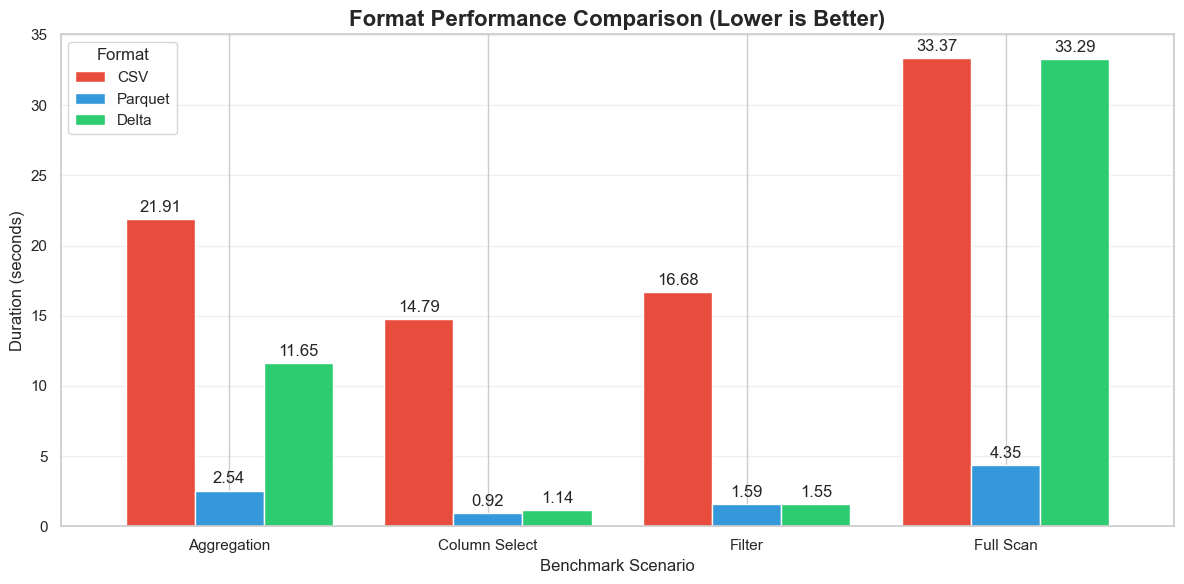

✓ Plot saved to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\plots\format_performance_comparison.png


In [18]:
# Analyze benchmark results
import pandas as pd
import matplotlib.pyplot as plt
from config import BENCHMARK_LOG_FILE, PLOTS_DIR

if not BENCHMARK_LOG_FILE.exists():
    print(f"File not found: {BENCHMARK_LOG_FILE}")
else:
    # 1. Load Data directly with Pandas
    try:
        df = pd.read_csv(BENCHMARK_LOG_FILE)
        
        # Filter only SUCCESS runs
        results_df = df[df['status'] == 'SUCCESS'].copy()
        
        if results_df.empty:
            print("Log file found, but no SUCCESS results yet.")
            print("Content preview:\n", df.head())
        else:
            # Convert duration to numeric
            results_df['duration_seconds'] = pd.to_numeric(results_df['duration_seconds'], errors='coerce')

            print("\n" + "="*70)
            print(f"BENCHMARK RESULTS SUMMARY ({len(results_df)} runs found)")
            print("="*70)
            # Show the last 15 runs to confirm we see the new ones
            print(results_df[['test_name', 'duration_seconds', 'status']].tail(15).to_string(index=False))
            print("="*70)

            # --- Visualization Logic ---
            def extract_format_and_test(test_name):
                # Detect Format
                if 'CSV' in test_name: fmt = 'CSV'
                elif 'Parquet' in test_name: fmt = 'Parquet'
                elif 'Delta' in test_name: fmt = 'Delta'
                else: fmt = 'Unknown'
                
                # Detect Test Type
                if 'Full Scan' in test_name: test = 'Full Scan'
                elif 'Aggregation' in test_name: test = 'Aggregation'
                elif 'Filter' in test_name: test = 'Filter'
                elif 'Select 2 Columns' in test_name: test = 'Column Select'
                else: test = 'Other'
                
                return fmt, test

            # Apply categorization
            results_df[['format', 'test_type']] = results_df['test_name'].apply(
                lambda x: pd.Series(extract_format_and_test(x))
            )

            # Filter relevant tests for the plot
            comparison_tests = results_df[
                results_df['test_type'].isin(['Full Scan', 'Aggregation', 'Filter', 'Column Select'])
            ].copy()

            # Take only the LATEST run for each (Format, TestType) combination
            # This prevents plotting old/duplicate runs
            latest_comparison = comparison_tests.sort_values('timestamp').groupby(['format', 'test_type']).tail(1)

            if not latest_comparison.empty:
                # Pivot for plotting
                pivot_data = latest_comparison.pivot_table(
                    index='test_type',
                    columns='format',
                    values='duration_seconds'
                )

                # Reorder columns if present
                for col in ['CSV', 'Parquet', 'Delta']:
                    if col not in pivot_data.columns:
                        pivot_data[col] = 0
                pivot_data = pivot_data[['CSV', 'Parquet', 'Delta']]

                # Plot
                fig, ax = plt.subplots(figsize=(12, 6))
                pivot_data.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db', '#2ecc71'], width=0.8)

                ax.set_title('Format Performance Comparison (Lower is Better)', fontsize=16, fontweight='bold')
                ax.set_ylabel('Duration (seconds)', fontsize=12)
                ax.set_xlabel('Benchmark Scenario', fontsize=12)
                ax.legend(title='Format')
                ax.grid(axis='y', alpha=0.3)
                plt.xticks(rotation=0)
                
                # Add value labels
                for container in ax.containers:
                    ax.bar_label(container, fmt='%.2f', padding=3)

                plt.tight_layout()
                plt.savefig(PLOTS_DIR / 'format_performance_comparison.png', dpi=300, bbox_inches='tight')
                plt.show()
                print(f"✓ Plot saved to: {PLOTS_DIR / 'format_performance_comparison.png'}")
            else:
                print("No matching data for visualization found.")

    except Exception as e:
        print(f"Error reading log file: {e}")

## Summary Report

In [19]:
# Print comprehensive benchmark summary
try:
    print_benchmark_summary()
except Exception as e:
    print(f'Note: Could not load benchmark summary: {e}')
    print('This is normal on first run - results are still being logged.')

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print("""
Expected Performance Characteristics:

1. STORAGE EFFICIENCY:
   - Parquet/Delta: 50-70% smaller than CSV due to compression
   - Columnar format benefits: Better compression ratios

2. FULL SCAN PERFORMANCE:
   - CSV: Slowest (row-oriented, no compression)
   - Parquet/Delta: Faster (columnar, compressed)

3. AGGREGATION PERFORMANCE:
   - Columnar formats excel: Only read required columns
   - CSV must read all columns regardless

4. FILTER PUSHDOWN:
   - Parquet/Delta: Support predicate pushdown
   - Delta: Additional data skipping with statistics

5. COLUMN PROJECTION:
   - Parquet/Delta: Huge advantage when selecting few columns
   - CSV: Must read entire row even for single column
""")
print("="*80)
print("\n✓ Format benchmark completed!")
print("Next step: Run notebook 03_join_optimization.ipynb")
print("="*80)


BENCHMARK SUMMARY

Test Name                                Duration        Status    
---------------------------------------- --------------- ----------
Read CSV - fact_transactions (Full Scan) 33.4s           SUCCESS   
Read Parquet - fact_transactions (Full S 4.3s            SUCCESS   
Read Delta - fact_transactions (Full Sca 33.3s           SUCCESS   
CSV - Aggregation by Category            21.9s           SUCCESS   
Parquet - Aggregation by Category        2.5s            SUCCESS   
Delta - Aggregation by Category          11.6s           SUCCESS   
CSV - Filter Electronics Category        16.7s           SUCCESS   
Parquet - Filter Electronics Category    1.6s            SUCCESS   
Delta - Filter Electronics Category      1.6s            SUCCESS   
CSV - Select 2 Columns                   14.8s           SUCCESS   
Parquet - Select 2 Columns               0.9s            SUCCESS   
Delta - Select 2 Columns                 1.1s            SUCCESS   

---------------------------